# Assign Free Stream and Turbulence

For each FLORIS model and each saved SOWFA simulation, determine the best free stream wind as that which minimizes the error relative to the upstream-most turbines power production

Note the subtle difference is mostly connected to # of points on rotor

Then use the previously defined TI function to determine an ambient TI using the power method applied to upstream-most turbines.  Note that the new Gauss versions (Gauss and Gauss_Tune) will use this, while Gauss_Legacy will use the fit values

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_03.p", "rb" ) )
fi_dict = pickle.load( open( "floris_models.p", "rb" ) )

## List the unique precursors

In [3]:
def power_error(ws,sowfa_power, upstream_indicies, fi):
    fi.reinitialize_flow_field(wind_speed=[ws])
    fi.calculate_wake()
    floris_power = np.mean(np.array(fi.get_turbine_power())[upstream_indicies]) / 1000.
    return (sowfa_power - floris_power)**2

In [4]:
## Work out free-stream wind speed for each fi

for floris_key in fi_dict:
    (fi, floris_color, floris_label) = fi_dict[floris_key]

    free_stream_ws = []
    for i, row in df.iterrows():

        # Match the layout
        fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y])

        # Grab the upstream turbine
        wake_table = row.wake_table
        upstream_indicies = np.where(wake_table==0)[0]
        sowfa_power = np.mean(row['power'][upstream_indicies])
        # upstream_columns = ['sowfa_power_%d' % upstream_idx for upstream_idx in upstream_indicies]
        # sowfa_power = np.mean(row[upstream_columns])

        # Find the min error wind speed and assign in
        result = minimize(power_error, args=(sowfa_power, upstream_indicies, fi),x0=8.0)
        free_stream_ws.append(result.x[0])

    # Assign into the dataframe
    freestream_name = 'freestream_' + floris_label
    df[freestream_name] = free_stream_ws
        

In [5]:
## Assign free-stream TI directly without referecnce to floris model
free_stream_ti = []
for i, row in df.iterrows():

    # Grab the upstream turbine
    wake_table = row.wake_table
    upstream_indicies = np.where(wake_table==0)[0]
    ti_mean = np.mean(row['ti'][upstream_indicies])
    
    free_stream_ti.append(ti_mean)

# Assign into the dataframe
freestream_name = 'freestream_ti'
df[freestream_name] = free_stream_ti

In [6]:
df.head()

,Precursor,case_name,floris_TI,floris_U0,layout_x,layout_y,num_turbines,path,sim_length,sowfa_TI,sowfa_U0,yaw,power,ti,wake_table,freestream_gauss,freestream_gauss_legacy,freestream_ti
casename,,,,,,,,,,,,,,,,,,
c_0,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y-20,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[-20.0, 0.0]","[1697.0, 1445.7]","[0.09703534975568191, 0.16729992046512362]","[0, 1]",8.031730,8.010499,0.097035
c_1,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1937.5, 1072.3]","[0.09297835821594881, 0.17988567028143654]","[0, 1]",8.394857,8.372666,0.092978
c_2,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y20,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[20.0, 0.0]","[1688.3, 966.6]","[0.0853431860270954, 0.1327437170885774]","[0, 1]",8.017935,7.996741,0.085343
c_3,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R00_y-20,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[-20.0, 0.0]","[1699.3, 907.2]","[0.09688156249065837, 0.12228484151676836]","[0, 1]",8.035369,8.014128,0.096882
c_4,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R00_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,8.0,"[0.0, 0.0]","[1938.0, 752.7]","[0.09285372321562335, 0.10368956548356832]","[0, 1]",8.395580,8.373387,0.092854


In [7]:
# Save the updated dataframe
pickle.dump( df, open( "sowfa_04.p", "wb" ) )

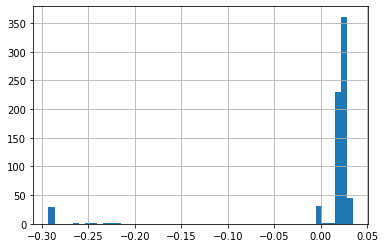

In [64]:
# Compare the distributions
df['difference'] = df.freestream_gauss - df.freestream_gauss_legacy
df.difference.hist(bins=50)

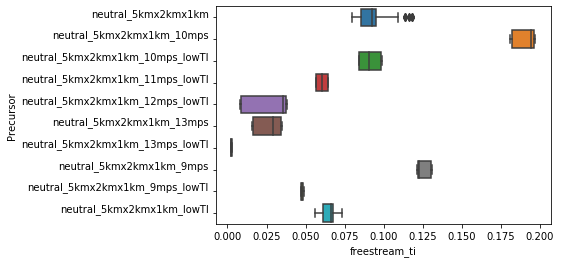

In [12]:
sns.boxplot(data=df,x='freestream_ti',y='Precursor')